# Goal

Using gradient descent, find the correct array _index_ to set to one.

In [7]:
import numpy as np
import jax.numpy as jnp
from jax import value_and_grad, jit, random
from matplotlib import pyplot as plt
from scipy import signal

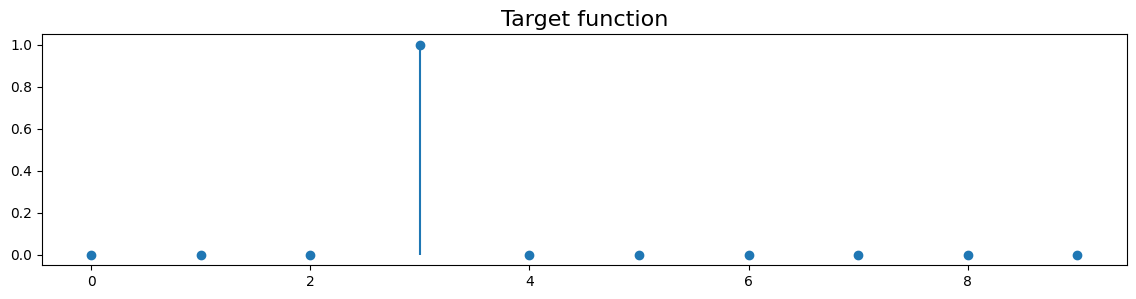

In [8]:
Y = np.zeros(10)
target_index = 3
Y[3] = 1.0

plt.figure(figsize=(14, 3))
plt.stem(Y, basefmt=' ')
_ = plt.title('Target function', size=16)

In [9]:
def correlation(X, Y):
    return 1 - jnp.correlate(X, Y).mean()


def mse(X, Y):
    return ((Y - X) ** 2).mean()


def mae(X, Y):
    return jnp.abs(Y - X).mean()

In [10]:
def single_index(index, key=None):
    X = jnp.zeros(Y.size)
    return X.at[index.astype('int32')].set(1.0)

In [11]:
def linear_interp_index(index, key=None):
    X = jnp.zeros(Y.size)
    i0 = jnp.floor(index)
    i1 = i0 + 1
    X = X.at[i0.astype('int32')].set(i1 - index)
    return X.at[i1.astype('int32')].set(index - i0)

In [12]:
def mean_interp_index(index, num_mean, key=None):
    X = jnp.zeros(Y.size)
    i0 = jnp.floor(index)
    i1 = i0 + 1
    X = X.at[i0.astype('int32')].set(i1 - index)
    return X.at[i1.astype('int32')].set(index - i0)

In [13]:
def gaussian(x, x0, sigma):
    return jnp.exp(-((x - x0) / sigma) ** 2 / 2)


def gaussian_interp_index(index, key=None):
    return gaussian(jnp.arange(Y.size), index, 2.0)

In [14]:
def gaussian_sample_index(index, key):
    weights = gaussian(jnp.arange(Y.size), index, 3.0)
    discrete_index = random.choice(key, Y.size, p=weights)
    index_array = jnp.zeros(Y.size)
    return index_array.at[discrete_index].set(1.0)

In [15]:
import scipy.signal


def window(size):
    return signal.blackmanharris()

In [16]:
def triangle(X, center):
    return 1 - jnp.abs(X - center) / jnp.max(X - center)


def triangle_interp_index(index):
    return triangle(jnp.arange(Y.size), index)

In [17]:
def index_loss(index_guess, create_indices_fn, key):
    X = create_indices_fn(index_guess, key=key)
    return mse(X, Y)

In [18]:
from functools import partial


def optimize(create_indices_fn, index_guess, steps=10):
    key = random.PRNGKey(0)
    loss_fn = partial(index_loss, create_indices_fn=create_indices_fn)
    grad_fn = jit(value_and_grad(loss_fn))
    estimated_index = index_guess
    initial_loss, _ = grad_fn(estimated_index, key=key)
    key, subkey = random.split(key)
    for train_i in range(steps):
        loss, grad = grad_fn(estimated_index, key=key)
        key, subkey = random.split(key)
        estimated_index -= grad
    return estimated_index, initial_loss, loss

In [19]:
def plot_optimized_indexes(create_indices_fn, start_indices=np.linspace(0, Y.size - 1, 90, endpoint=False), steps=20):
    fig, plots = plt.subplots(3, 1, figsize=(14, 8))
    estimated_index_plot, initial_loss_plot, optimized_loss_plot = plots
    optimized = np.array([optimize(create_indices_fn, start_index, steps=steps) for start_index in start_indices])
    estimated_index_plot.plot(start_indices, optimized[:, 0], linewidth=3)
    estimated_index_plot.set_title('Estimated index', size=18)
    estimated_index_plot.set_ylabel('Estimated index after {} steps'.format(steps), size=11)
    estimated_index_plot.axhline(target_index, linestyle='--', c='r', label='Target index')
    estimated_index_plot.legend()
    initial_loss_plot.plot(start_indices, optimized[:, 1], linewidth=3)
    initial_loss_plot.set_title('Initial loss', size=18)
    initial_loss_plot.set_ylabel('Initial MSE loss'.format(steps), size=11)
    optimized_loss_plot.plot(start_indices, optimized[:, 2], linewidth=3)
    optimized_loss_plot.set_title('Optimized loss', size=18)
    optimized_loss_plot.set_xlabel('Initial guess for index value', size=16)
    optimized_loss_plot.set_ylabel('MSE loss after {} steps'.format(steps), size=11)
    for plot in plots:
        plot.grid(True)
        plot.set_xticks(np.arange(Y.size))
    plt.tight_layout()
    plt.grid(True)

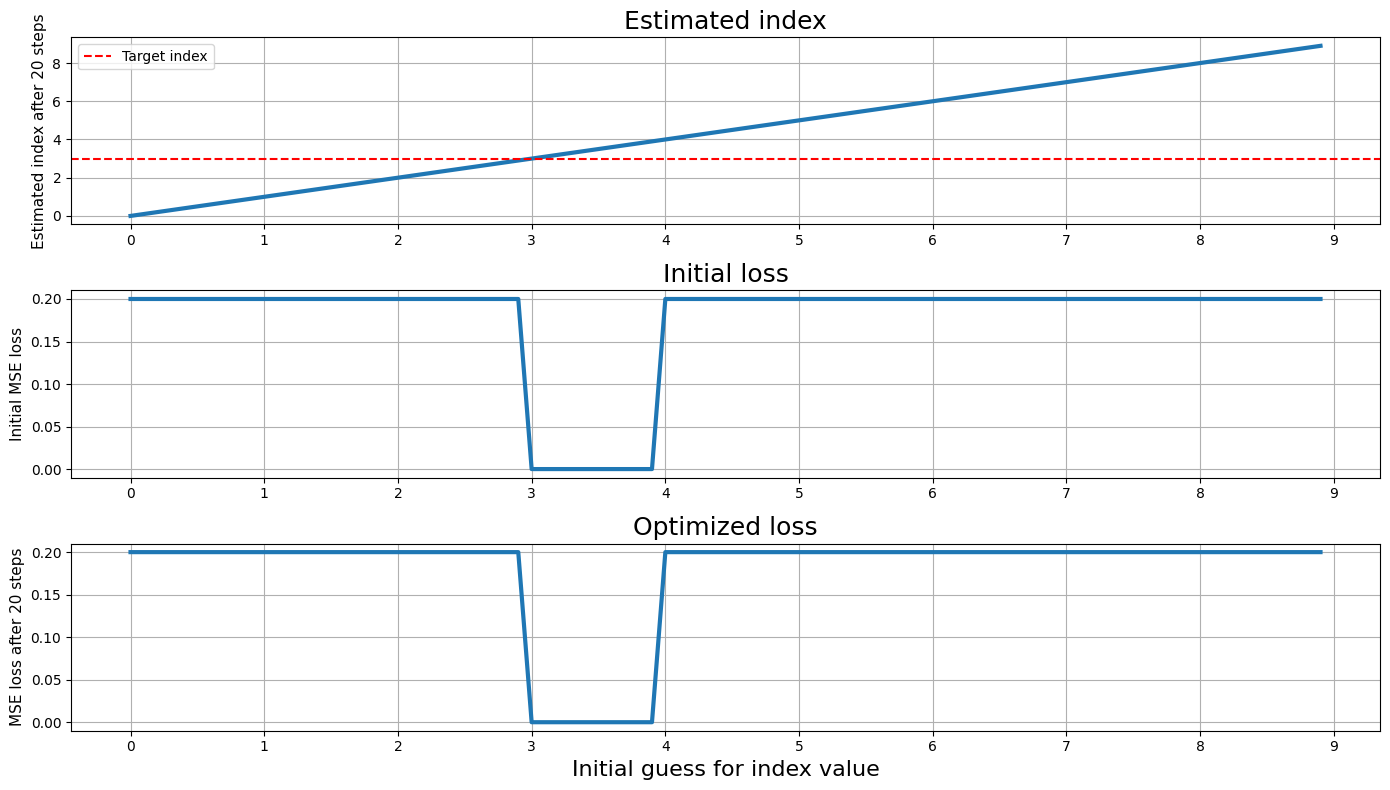

In [20]:
plot_optimized_indexes(single_index)

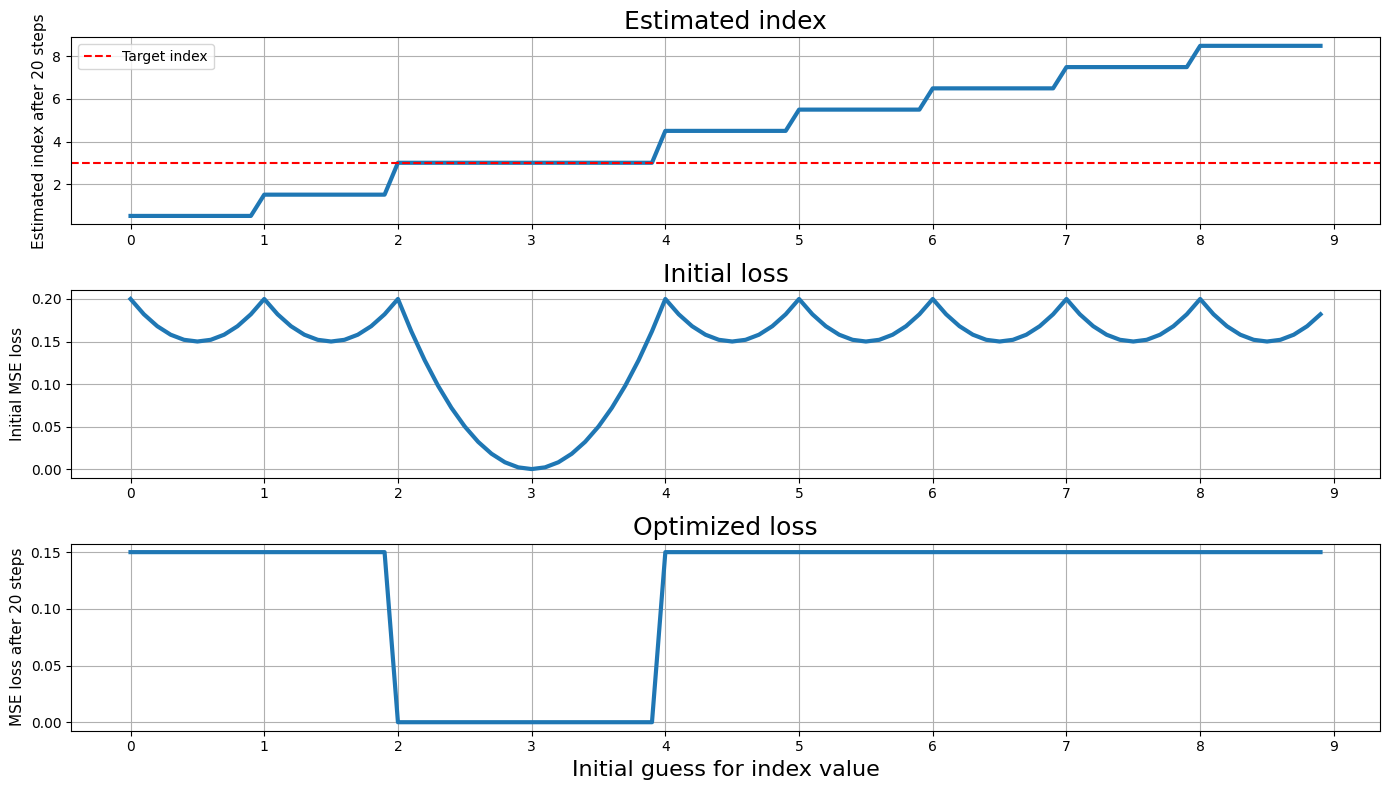

In [21]:
plot_optimized_indexes(linear_interp_index)

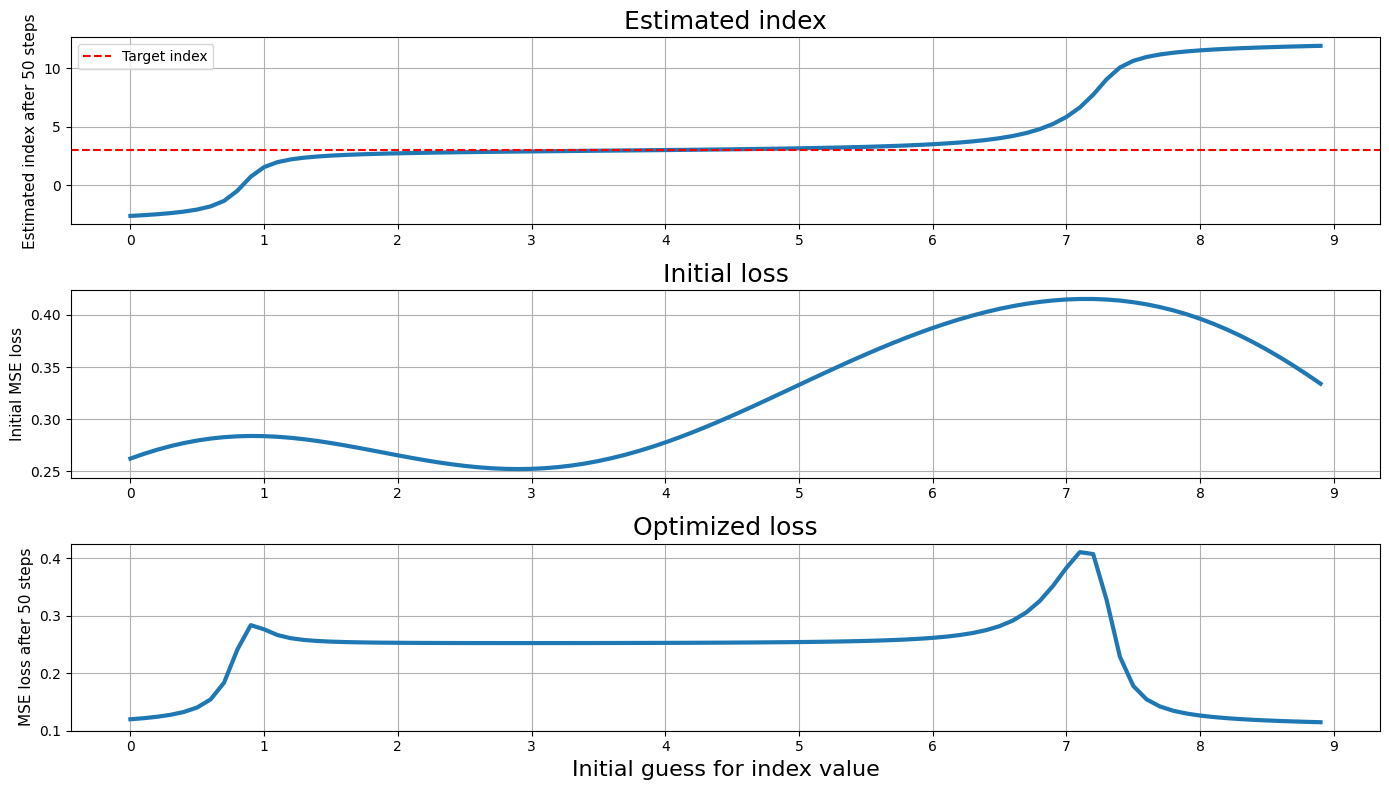

In [22]:
# What's happening is that at the edges, moving the gaussian distribution removes some of the mass from the
# smooth-indexing array that's being compared with target array (unit impulse at some target index).
# As mass is removed, MSE loss decreases since the area under the gaussian curve and the zeros in the target
# array decreases.
# TODO might be able to extend the successful range by using a different distribution.
# Ideal distribution would be smooth, with constant area under the curve, extending the full window,
# with skew centered around a parameter.
# There's also https://stackoverflow.com/questions/46926809/getting-around-tf-argmax-which-is-not-differentiable
plot_optimized_indexes(gaussian_interp_index, steps=50)

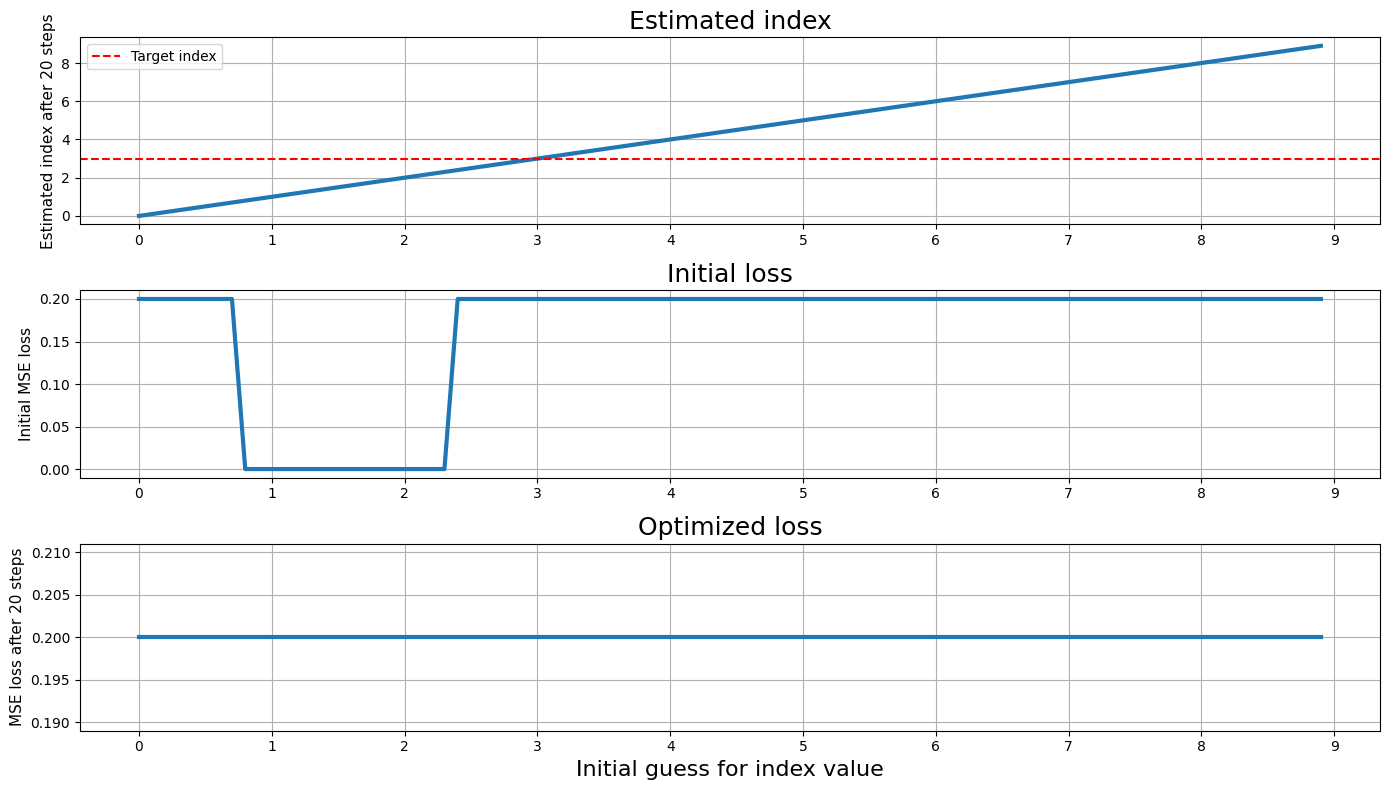

In [23]:
plot_optimized_indexes(gaussian_sample_index, steps=20)  # don't get why this is constant optimized loss

In [24]:
summed = jnp.zeros(Y.size)
key = random.PRNGKey(0)
for _ in range(100):
    a = gaussian_sample_index(4.2, key)
    key, subkey = random.split(key)
    summed += a
summed

Array([ 4.,  3., 12., 16., 18., 14., 11.,  9.,  9.,  4.], dtype=float32)

In [25]:
# What about exploring different distance measures that could provide a gradient for similar,
# but delayed, signals  (as opposed to MSE)?

# https://docs.scipy.org/doc/scipy/reference/spatial.distance.html
import numpy as np
from scipy.spatial import distance
from scipy.stats import wasserstein_distance

# from fastdtw import fastdtw

# def dtw(x, y):
#     dist, path = fastdtw(x, y, dist=distance.euclidean)
#     return dist

distance_measures = [
    distance.braycurtis,
    distance.canberra,
    distance.chebyshev,
    distance.cityblock,
    distance.correlation,
    distance.cosine,
    distance.euclidean,
    distance.jensenshannon,
    distance.minkowski,
    distance.sqeuclidean,
    wasserstein_distance,
    #     fastdtw(x, y, dist=distance.euclidean)
    #    dtw,
]


def array_with_one_at(i):
    ar = np.zeros(8)
    ar[i] = 1.0
    return ar


a = array_with_one_at(2)

{distance_measure.__name__: ['{:.2f}'.format(distance_measure(a, array_with_one_at(i))) for i in range(a.size)] for
 distance_measure in distance_measures}
# Nope - these all have the same distance regardless of the `1.0` position.
# That is, none seem to be order-dependent :( Even DTW doesn't seem right for this simple 1d case

{'braycurtis': ['1.00',
  '1.00',
  '0.00',
  '1.00',
  '1.00',
  '1.00',
  '1.00',
  '1.00'],
 'canberra': ['2.00', '2.00', '0.00', '2.00', '2.00', '2.00', '2.00', '2.00'],
 'chebyshev': ['1.00', '1.00', '0.00', '1.00', '1.00', '1.00', '1.00', '1.00'],
 'cityblock': ['2.00', '2.00', '0.00', '2.00', '2.00', '2.00', '2.00', '2.00'],
 'correlation': ['1.14',
  '1.14',
  '0.00',
  '1.14',
  '1.14',
  '1.14',
  '1.14',
  '1.14'],
 'cosine': ['1.00', '1.00', '0.00', '1.00', '1.00', '1.00', '1.00', '1.00'],
 'euclidean': ['1.41', '1.41', '0.00', '1.41', '1.41', '1.41', '1.41', '1.41'],
 'jensenshannon': ['0.83',
  '0.83',
  '0.00',
  '0.83',
  '0.83',
  '0.83',
  '0.83',
  '0.83'],
 'minkowski': ['1.41', '1.41', '0.00', '1.41', '1.41', '1.41', '1.41', '1.41'],
 'sqeuclidean': ['2.00',
  '2.00',
  '0.00',
  '2.00',
  '2.00',
  '2.00',
  '2.00',
  '2.00'],
 'wasserstein_distance': ['0.00',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  '0.00']}